Imports

In [2]:
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from transformers import AutoModelForSequenceClassification

c:\Users\Nathaniel\Documents\Python\Presidential Tweet Sentiment Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Preprocessing

In [22]:
folder_path = 'tweets-data'

ganjar_path = 'ganjardebat.csv'
mahfud_path = 'mahfuddebat.csv'

prabowo_path = 'prabowodebat.csv'
gibran_path = 'gibrandebat.csv'

anies_path = 'aniesdebat.csv'
imin_path = 'imindebat.csv'

In [23]:
def process_df(file_path):
    df = pd.read_csv(file_path)

    df.drop(['id_str', 'quote_count', 'reply_count', 'retweet_count',
             'favorite_count', 'lang', 'user_id_str', 'conversation_id_str',
             'username', 'tweet_url'], axis=1, inplace=True)

    df.columns = ['date', 'tweet']

    df['tweet'] = df['tweet'].str.lower()
    df['date'] = pd.to_datetime(df['date'], format="%a %b %d %H:%M:%S +0000 %Y")
    return df

In [24]:
def get_full_path(file_name):
    return os.path.join(folder_path, file_name)

In [25]:
# Ganjar DF
ganjar_df = process_df(get_full_path(ganjar_path))
# Mahfud DF
mahfud_df = process_df(get_full_path(mahfud_path))

# Prabowo DF
prabowo_df = process_df(get_full_path(prabowo_path))
# Gibran DF
gibran_df = process_df(get_full_path(gibran_path))

# Anies DF
anies_df = process_df(get_full_path(anies_path))
# Imin DF
imin_df = process_df(get_full_path(imin_path))

df_paths = [ganjar_df, mahfud_df, prabowo_df, gibran_df, anies_df, imin_df]

In [26]:
display(ganjar_df.head())
print(f"\nDimensions: {ganjar_df.shape[0]} rows × {ganjar_df.shape[1]} columns")

,date,tweet
0,2024-01-09 23:59:50,ganjar mahfud hebat #coblos3 #ganjarmahfudm3na...
1,2024-01-09 23:59:48,@zarryhendrik mohon maaf ini footage ga sinkro...
2,2024-01-09 23:59:45,"@abeearief @love_um4m4 mana fotonya, mana reka..."
3,2024-01-09 23:59:42,@melihat_indo semangat terus untuk selalu berj...
4,2024-01-09 23:59:42,@hasyimmah anda salah. pendukung jokowi yg kom...



Dimensions: 2002 rows × 2 columns


In [8]:
cleaning_re = r'https?:\S+|http?:\S|\d+|[^A-Za-z0-9]+|[^\w\s]'
def remove_mentions(text):
    text = re.sub(r'#\S+', ' ', text)
    text = re.sub(r'@\S+', ' ', text)
    text = re.sub(cleaning_re, ' ', text)
    return text

In [9]:
for df in df_paths:
    df['tweet'] = df['tweet'].apply(remove_mentions)

In [10]:
display(gibran_df.head())
print(f"\nDimensions: {gibran_df.shape[0]} rows × {gibran_df.shape[1]} columns")

,date,tweet
0,2024-01-09 23:59:55,menghancurkan rezim sangat mudah dengan tidak...
1,2024-01-09 23:59:53,semangat beraktivitas prabowo gibran akan sel...
2,2024-01-09 23:59:50,mas gibran memang keren dan sangat luar biasa
3,2024-01-09 23:59:40,gibran adalah sosok yang tidak hanya pandai d...
4,2024-01-09 23:59:40,keren bngt si pake kaos samsul



Dimensions: 1941 rows × 2 columns


In [11]:
# Check data types
gibran_df.dtypes

date     datetime64[ns]
tweet            object
dtype: object

In [12]:
def remove_duplicate(dfs):
    for i, df in enumerate(dfs):
        dfs[i] = df.drop_duplicates(subset=['tweet'])
    return dfs

df_paths = remove_duplicate(df_paths)

Tokenize

In [13]:
tokenizer = AutoTokenizer.from_pretrained("ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa")

def tokenize_tweets(dfs, tokenizer):
    for i, df in enumerate(dfs):
        tokenized = tokenizer(df['tweet'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)

        df_copy = df.copy()

        df_copy.loc[:, 'input_ids'] = tokenized['input_ids'].tolist()
        df_copy.loc[:, 'attention_mask'] = tokenized['attention_mask'].tolist()

        dfs[i] = df_copy
    return dfs

df_paths = tokenize_tweets(df_paths, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/476k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa")

model.eval()

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Making predictions for DataFrame 1
                 date                                              tweet  \
0 2024-01-09 23:59:50                           ganjar mahfud hebat oh     
1 2024-01-09 23:59:48   mohon maaf ini footage ga sinkron dgn percaka...   
2 2024-01-09 23:59:45   mana fotonya mana rekamannya lu bisa nongkron...   
3 2024-01-09 23:59:42   semangat terus untuk selalu berjuang pak ganj...   
4 2024-01-09 23:59:42   anda salah pendukung jokowi yg komit pd demok...   

                                           input_ids  \
0  [3, 24195, 1008, 2411, 13295, 1006, 8893, 8261...   
1  [3, 18586, 11722, 1542, 9022, 5110, 3879, 2212...   
2  [3, 2369, 21209, 1508, 2369, 27475, 3500, 2223...   
3  [3, 6794, 3144, 1572, 3413, 7927, 3426, 24195,...   
4  [3, 5344, 1891, 4659, 15071, 7889, 1736, 1531,...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1,

In [ ]:
def make_predictions(df, model):
    input_ids = torch.tensor(df['input_ids'].tolist())
    attention_mask = torch.tensor(df['attention_mask'].tolist())

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    predictions = torch.argmax(outputs.logits, dim=1).tolist()

    return predictions


In [ ]:
for i, df in enumerate(df_paths):
    print(f"Making predictions for DataFrame {i + 1}")
    
    print(df.head())

    predictions = make_predictions(df, model)
    print(predictions[:5])

    df['predictions'] = predictions

    df_paths[i] = df

In [34]:
ganjar_df_sentiment = df_paths[0]
mahfud_df_sentiment = df_paths[1]

prabowo_df_sentiment = df_paths[2]
gibran_df_sentiment = df_paths[3]

anies_df_sentiment = df_paths[4]
imin_df_sentiment = df_paths[5]

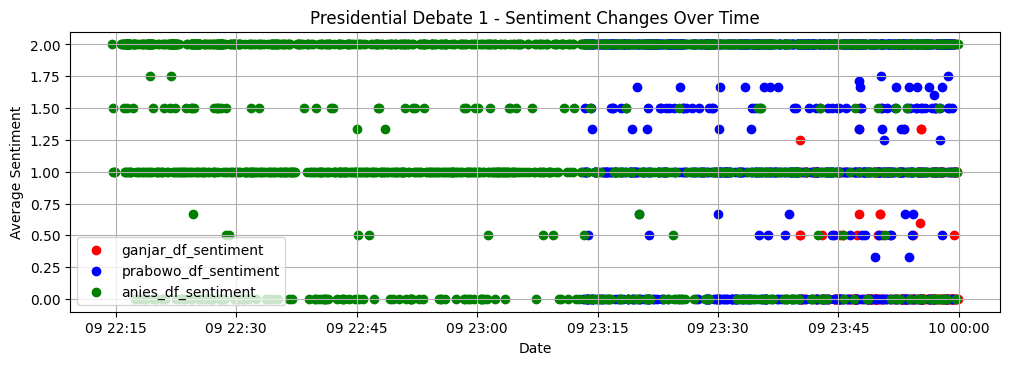

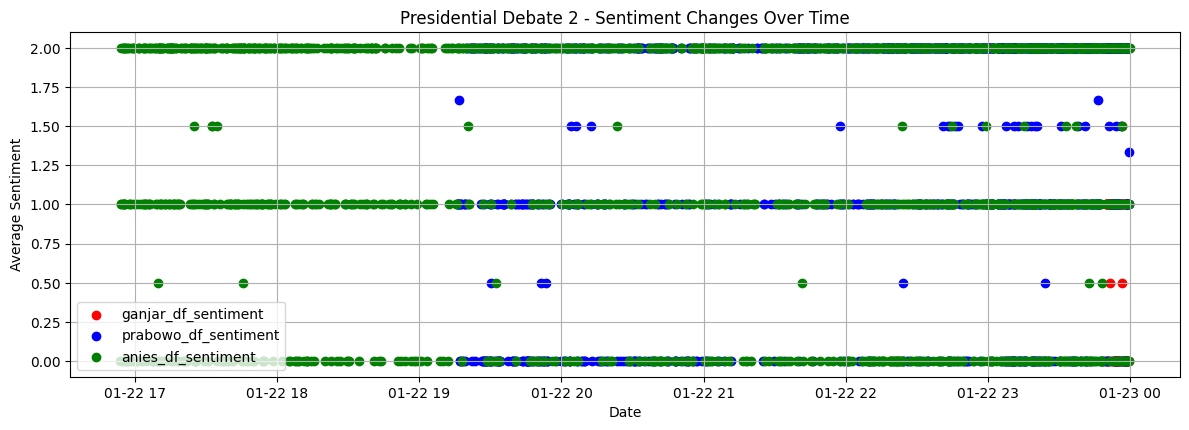

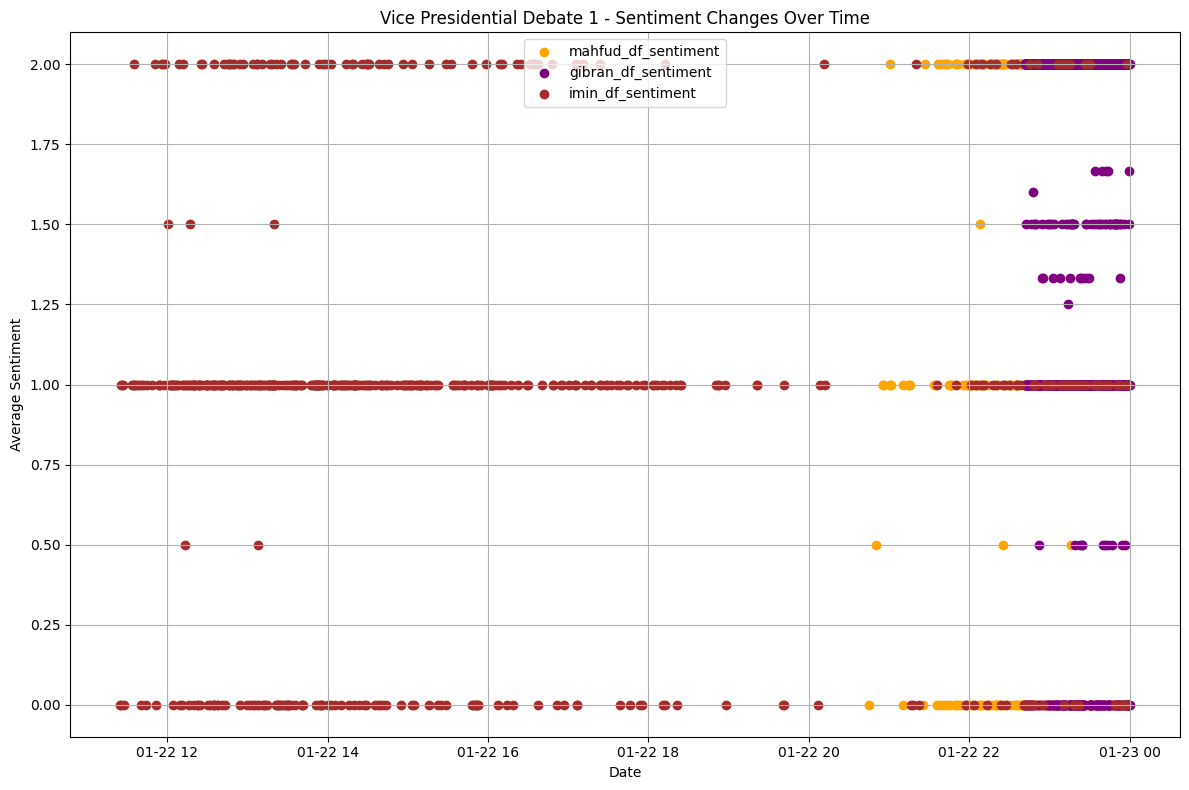

In [37]:
candidate_colors = {
    'ganjar_df_sentiment': 'red',
    'prabowo_df_sentiment': 'blue',
    'anies_df_sentiment': 'green',
    'mahfud_df_sentiment': 'orange',
    'gibran_df_sentiment': 'purple',
    'imin_df_sentiment': 'brown',
}

debate_dates = {
    'presidential_debate_1': ('2024-01-07', '2024-01-10'),
    'presidential_debate_2': ('2024-01-21', '2024-01-23'),
    'vice_presidential_debate_1': ('2024-01-21', '2024-01-23'),
}

def filter_date_range(df, start_date, end_date):
    return df[(df['date'] >= start_date) & (df['date'] <= end_date)]

def create_scatter_plot(df, start_date, end_date, label, color):
    df_filtered = filter_date_range(df, start_date, end_date)
    daily_sentiment = df_filtered.groupby('date')['predictions'].mean()
    plt.scatter(daily_sentiment.index, daily_sentiment.values, label=label, color=color)

# Scatter plots for Presidential Debate 1
plt.figure(figsize=(12, 8))
for candidate, color in candidate_colors.items():
    if candidate in ['ganjar_df_sentiment', 'prabowo_df_sentiment', 'anies_df_sentiment']:
        plt.subplot(2, 1, 1)
        create_scatter_plot(eval(candidate), *debate_dates['presidential_debate_1'], candidate, color)

plt.title('Presidential Debate 1 - Sentiment Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.legend()
plt.grid(True)

# Scatter plots for Presidential Debate 2
plt.figure(figsize=(12, 8))
for candidate, color in candidate_colors.items():
    if candidate in ['ganjar_df_sentiment', 'prabowo_df_sentiment', 'anies_df_sentiment']:
        plt.subplot(2, 1, 2)
        create_scatter_plot(eval(candidate), *debate_dates['presidential_debate_2'], candidate, color)

plt.title('Presidential Debate 2 - Sentiment Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Scatter plots for Vice Presidential Debate 1
plt.figure(figsize=(12, 8))
for candidate, color in candidate_colors.items():
    if candidate in ['mahfud_df_sentiment', 'gibran_df_sentiment', 'imin_df_sentiment']:
        plt.subplot(1, 1, 1)
        create_scatter_plot(eval(candidate), *debate_dates['vice_presidential_debate_1'], candidate, color)

plt.title('Vice Presidential Debate 1 - Sentiment Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [49]:
df_paths = [ganjar_df_sentiment, prabowo_df_sentiment, anies_df_sentiment, mahfud_df_sentiment, gibran_df_sentiment, imin_df_sentiment]

sentiment_classes = ['Positive', 'Neutral', 'Negative']
candidates = ['Ganjar', 'Prabowo', 'Anies', 'Mahfud', 'Gibran', 'Imin']

results = {}


Ganjar:

Predicted Class Counts:
Positive     89
Neutral     119
Negative    193
Name: predicted_class, dtype: int64

Predicted Class Percentages:
Positive    22.19
Neutral     29.68
Negative    48.13
Name: predicted_class, dtype: float64
------------------------------

Prabowo:

Predicted Class Counts:
Positive    1608
Neutral      740
Negative     526
Name: predicted_class, dtype: int64

Predicted Class Percentages:
Positive    55.95
Neutral     25.75
Negative    18.30
Name: predicted_class, dtype: float64
------------------------------

Anies:

Predicted Class Counts:
Positive    1491
Neutral      891
Negative     543
Name: predicted_class, dtype: int64

Predicted Class Percentages:
Positive    50.97
Neutral     30.46
Negative    18.56
Name: predicted_class, dtype: float64
------------------------------

Mahfud:

Predicted Class Counts:
Positive     422
Neutral      425
Negative    1171
Name: predicted_class, dtype: int64

Predicted Class Percentages:
Positive    20.91
Neutral     

In [ ]:
for candidate, df in zip(candidates, df_paths):
    df['predicted_class'] = df['predictions'].map({2: 'Positive', 1: 'Neutral', 0: 'Negative'})

    class_counts = df['predicted_class'].value_counts()

    class_percentages = (class_counts / class_counts.sum()) * 100
    class_percentages = class_percentages.round(2)

    results[candidate] = {
        'class_counts': class_counts,
        'class_percentages': class_percentages
    }

In [ ]:

for candidate, result in results.items():
    print(f"\n{candidate}:\n")
    print(f"{'Predicted Class Counts:':<20}")
    print(result['class_counts'].loc[sentiment_classes])
    print(f"\n{'Predicted Class Percentages:':<20}")
    print(result['class_percentages'].loc[sentiment_classes])
    print("-" * 30)